# <center> Systematic Trading Strategies with Machine Learning Algorithms </center>

## <center>Programming Session 3 - Introducing discrete HMMs
</center>
<center>
<table class="tfo-notebook-buttons" style="margin-left: auto; margin-right: auto;">
  <tr>
    <td style="text-align: center; vertical-align: middle;">
      <a target="_blank" href="https://hm-ai.github.io/Systematic_Trading_Strategies_with_Machine_Learning_Algorithms/">
        <img src="https://drive.google.com/uc?export=view&id=1hTIoxoea8RTLgKb1oE6_PFmtTNPGs5p4" height="50"/>
        <br>Course page
      </a>
    </td>
    <td style="text-align: center; vertical-align: middle;">
      <a target="_blank" href="https://colab.research.google.com/drive/14OiCp7UdI8-EKQiQ-C1FTXkLm9mwDSy3?usp=sharing">
        <img src="https://www.tensorflow.org/images/colab_logo_32px.png" height="50" />
        <br>Run in Google Colab
      </a>
    </td>
  </tr>
</table>
</center>



This notebook illustrates the fundamental concepts of Hidden Markov Models (HMMs) as introduced in the seminal paper by [Rabiner(1989)](https://www.ece.ucsb.edu/Faculty/Rabiner/ece259/Reprints/tutorial%20on%20hmm%20and%20applications.pdf).

We'll explore the following three problems of HMMs:

1. **The Evaluation Problem**: Computing the probability of an observation sequence given a model.
2. **The Learning Problem**: Estimating model parameters from a sequence of observations.
3. **The Prediction Problem**: Forecasting future states and observations based on historical observations.


<p align="center">
  <img src="https://media.giphy.com/media/BeurjzzpsYwqQ/giphy.gif" alt="Ross">
</p>

# Introducing the problem and Generating the data

Dr. Ross Geller, a paleontologist at New York University, faces a peculiar dilemma. Every day, he brings a delicious sandwich to work and stores it in the department refrigerator. However, his lunch frequently disappears before he can eat it.

Being a scientist, Dr. Geller decides to track whether his sandwich remains in the refrigerator each day. He can only **observe** one of two possible states:
- **0**: The sandwich is safe (still in the refrigerator)
- **1**: The sandwich is missing (someone ate it)

After collecting data for several months (1,000 observations), Dr. Geller wants to determine who might be responsible for his missing lunches and predict when future sandwiches might disappear.

<center><img width="500" src = "https://drive.google.com/uc?export=view&id=1oG74_aXIkxFlz_ppK6N5DBXwa0bYwx26"></center>


### Introducing the Hidden States

Through departmental gossip, Dr. Geller has narrowed down the potential culprits to two colleagues:

1. **Dr. Donald**: A sandwich enthusiast who has a high probability (0.9) of eating Ross's sandwich when present
2. **Dr. Charlie**: A more selective eater who only occasionally (with probability 0.5) takes the sandwich

Importantly, Dr. Donald and Dr. Charlie work on different schedules and are never present simultaneously. This creates three possible hidden states that Dr. Geller cannot directly observe:

- **State 0**: Dr. Donald is present (and Dr. Charlie is absent) - 90% chance the sandwich disappears
- **State 1**: Dr. Charlie is present (and Dr. Donald is absent) - 50% chance the sandwich disappears
- **State 2**: Neither colleague is present - 0% chance the sandwich disappears

<center><img width="500" src = "https://drive.google.com/uc?export=view&id=1CC6UoA7K5O7DLpbCqHYKtc6P13eSZjUs"></center>


### Introducing the Parameters of the Hidden Markov Model

We'll now define the key parameters of our Hidden Markov Model:

1. **Number of hidden states**: M = 3 (the three scenarios described above)
2. **Observation dimension**: D = 2 (sandwich is either present or missing)
3. **Number of observations**: N = 1,000 (days Dr. Geller recorded data)

Using the notation from our slides, our HMM is characterized by three key components:


- **Initial state distribution**: $\pi = \{\pi_0, \pi_1, \pi_2\}$, where $\pi_m = P(H_1 = m)$
- **Transition matrix**: $Q$, where $Q_{ij} = P(H_{t+1} = j \mid H_t = i)$
- **Emission matrix**: $O$, where $O_{mj} = P(\tilde{X}_t = o_j \mid H_t = m)$

### Generating the Synthetic Data

Let's begin by setting up our environment and generating synthetic data based on our HMM setup.

In [1]:
!pip install hmmlearn

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from hmmlearn.hmm import CategoricalHMM
# Set the random seed for reproducibility
np.random.seed(42)

In [3]:
# Define the parameters of our HMM
n_states = 3  # Number of hidden states (Donald present, Charlie present, Neither present)
n_observations = 2  # Number of possible observations (0: sandwich safe, 1: sandwich missing)
n_samples = 1000  # Number of days to simulate

Now, let's define the parameters of our HMM: $\pi$ (initial state distribution), $Q$ (transition matrix), and $O$ (emission matrix).

Here's the updated question with LaTeX code for the equations:

---
<font color=green>Q1:</font> <br><font color='green'>
Based on the description of the emission distributions, define the emission matrix O. Remember that $O_{mj} = P(\tilde{X}_t = o_j \mid H_t = m)$, where $o_0$ = "sandwich safe" and $o_1$ = "sandwich missing". Recall that:
- When Dr. Donald is present (state 0), there's a 90% chance the sandwich disappears
- When Dr. Charlie is present (state 1), there's a 50% chance the sandwich disappears
- When neither is present (state 2), there's a 0% chance the sandwich disappears
</font>  

---

<center><img width="500" src = "https://drive.google.com/uc?export=view&id=1HmR-xWY-PjXBuQWs9G_0dDsuMMllVJGh"></center>


In [4]:
# Define the emission matrix (O)
# O[m,j] = P(X̃ₜ = oⱼ | Hₜ = m)
O = np.array([
    [0.1, 0.9],  # State 0 (Donald): 10% safe, 90% eaten
    [0.5, 0.5],  # State 1 (Charlie): 50% safe, 50% eaten
    [1.0, 0.0]   # State 2 (Neither): 100% safe, 0% eaten
])

Now, let's define the transition matrix Q based on the state transition diagram:

<center><img width="300" src = "https://drive.google.com/uc?export=view&id=1DmyO8Ie_ESgyAGB2YDn2lq5_E1P7TW-v"></center>


---
<font color=green>Q2:</font> <br><font color='green'>
Using the state transition diagram above, define the transition matrix Q where $Q_{ij} = P(H_{t+1} = j \mid H_t = i)$. The arrows in the diagram represent the probabilities of transitioning from one state to another.
</font>  

---

In [5]:
# Define the transition matrix (Q)
# Q[i,j] = P(Hₜ₊₁ = j | Hₜ = i)
Q = np.array([
    [0.8, 0.1, 0.1],  # From State 0 (Donald present)
    [0.1, 0.7, 0.2],  # From State 1 (Charlie present)
    [0.2, 0.2, 0.6]   # From State 2 (Neither present)
])

Finally, let's define the initial state distribution as a uniform distribution:

In [6]:
# Define the initial state distribution ($\pi$)
pi = np.array([1, 1, 1])/3  # Initial probabilities for states 0, 1, and 2

---
<font color=green>Q3:</font> <br><font color='green'>
Write a function `generate_hmm_sequence(pi, Q, O, n_samples)` that generates a sequence of hidden states and observations based on the HMM parameters pi, Q, and O. The function should return two arrays: hidden_states and observations.
</font>  

---

<center><img width="500" src = "https://drive.google.com/uc?export=view&id=1eURJOKwaBrafYn7lH6aaEPcwEt4KW-N2"></center>

In [7]:
def generate_hmm_sequence(pi, Q, O, n_samples):
   """
   Generate a sequence of hidden states and observations from a Hidden Markov Model.

   Parameters:
   -----------
   pi : numpy.ndarray
       Initial state distribution vector of shape (n_states,)
       pi[m] = probability of starting in state m

   Q : numpy.ndarray
       Transition probability matrix of shape (n_states, n_states)
       Q[i,j] = probability of transitioning from state i to state j

   O : numpy.ndarray
       Emission probability matrix of shape (n_states, n_observations)
       O[m,j] = probability of observing j given we're in state m

   n_samples : int
       Number of time steps to simulate

   Returns:
   --------
   hidden_states : numpy.ndarray
       Sequence of hidden states (integers) of shape (n_samples,)

   observations : numpy.ndarray
       Sequence of observations (integers) of shape (n_samples,)
   """
   # Get the number of possible states from the shape of pi
   n_states = len(pi)

   # Get the number of possible observations from the shape of O
   n_observations = O.shape[1]

   # Initialize arrays to store the generated sequences
   hidden_states = np.zeros(n_samples, dtype=int)
   observations = np.zeros(n_samples, dtype=int)

   # Step 1: Sample the initial hidden state from the initial distribution pi
   # np.random.choice selects a state with probabilities given by pi
   hidden_states[0] = np.random.choice(np.arange(n_states), p=pi)

   # Step 2: Given the initial hidden state, sample the first observation
   # from the emission distribution of that state
   observations[0] = np.random.choice(np.arange(n_observations), p=O[hidden_states[0]])

   # Step 3: Generate the rest of the sequence
   for t in range(1, n_samples):
       # Sample the next hidden state based on the transition probabilities
       # from the current state (using the row of Q corresponding to the current state)
       hidden_states[t] = np.random.choice(np.arange(n_states), p=Q[hidden_states[t-1]])

       # Sample the observation at time t based on the emission probabilities
       # of the current hidden state
       observations[t] = np.random.choice(np.arange(n_observations), p=O[hidden_states[t]])

   return hidden_states, observations

---
<font color=green>Q4:</font> <br><font color='green'>
Use the `generate_hmm_sequence` function to generate a sequence of 1000 hidden states and observations based on our HMM parameters ($\pi$, $Q$, $O$). This will simulate 1000 days of Dr. Geller's sandwich saga. Store the results in variables called `hidden_states` and `observations`. Remember that `hidden_states` represents who was present each day (Donald, Charlie, or neither), while `observations` represents whether the sandwich was safe or missing each day.
</font>  

---

In [8]:
# Generate our synthetic data
hidden_states, observations = generate_hmm_sequence(pi, Q, O, n_samples)

---
<font color=green>Q5:</font> <br><font color='green'>
Now, write code to visualize a segment of our data to understand what it looks like. Plot the hidden states (who was present) and the observations (whether the sandwich was safe or missing) for the first 50 days.
</font>  

---

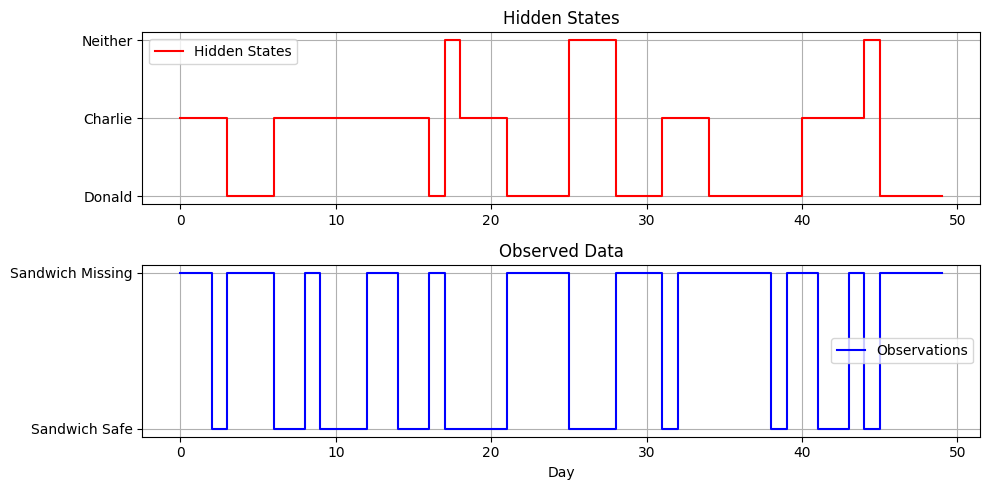

In [9]:
# Let's visualize a segment of our data to understand what it looks like
segment_length = 50  # Show first 50 days

plt.figure(figsize=(10, 5))

# Plot the hidden states
plt.subplot(2, 1, 1)
plt.step(range(segment_length), hidden_states[:segment_length], where='post',
         label='Hidden States', color='red')
plt.yticks([0, 1, 2], ['Donald', 'Charlie', 'Neither'])
plt.title('Hidden States')
plt.legend()
plt.grid(True)

# Plot the observations
plt.subplot(2, 1, 2)
plt.step(range(segment_length), observations[:segment_length], where='post',
         label='Observations', color='blue')
plt.yticks([0, 1], ['Sandwich Safe', 'Sandwich Missing'])
plt.title('Observed Data')
plt.xlabel('Day')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

This completes our data generation process. We now have:

1. Generated a synthetic dataset following our HMM assumptions
2. Visualized what Dr. Geller can actually observe versus the hidden ground truth

# The Learning Problem: EM Algorithm

Now that Dr. Geller has collected observations on whether his sandwich was present or missing each day, he wants to determine the underlying model. In a real-world scenario, he would not know the true parameters ($\pi$, $Q$, $O$) - he would only have the observations.

The learning problem focuses on estimating these parameters from the observation sequence. There are two mains methods for that:


* The **spectral method** described in the following paper [Hsu(2012)](https://arxiv.org/pdf/0811.4413.pdf). It is based on a Singular Value Decomposition (SVD) of a matrix derived from triplets of observations.

* The **Expectation Maximization** (EM) algorithm described in the [Rabiner(1989)](https://www.ece.ucsb.edu/Faculty/Rabiner/ece259/Reprints/tutorial%20on%20hmm%20and%20applications.pdf) and shown in the following figure


We'll use the Expectation-Maximization (EM) algorithm, also known as the Baum-Welch algorithm in the context of HMMs, as described in Rabiner (1989).

<center><img width="500" src = "https://drive.google.com/uc?export=view&id=1eZQ1tdhMv92WDWFoYVqaRLy2N3-mTrv8"></center>


### Fitting the Model Using hmmlearn

We'll use the `hmmlearn` library to implement the EM algorithm:

In [10]:
# Reshape the observations for hmmlearn (it expects a 2D array)
X = observations.reshape(-1, 1)

# Initialize a model with the correct number of hidden states
fitted_model = CategoricalHMM(n_components=n_states, n_iter=100, tol=1e-6, random_state=42)

# Fit the model to our observations
fitted_model.fit(X)

CategoricalHMM(n_components=3, n_features=np.int64(2), n_iter=100,
               random_state=RandomState(MT19937) at 0x7FA8E3BA0440, tol=1e-06)

---
<font color=green>Q6:</font> <br><font color='green'>
After fitting the model, extract the learned parameters (initial state distribution, transition matrix, and emission matrix)

For reference:
- The learned initial state distribution is stored in `fitted_model.startprob_`
- The learned transition matrix is stored in `fitted_model.transmat_`
- The learned emission matrix is stored in `fitted_model.emissionprob_`
</font>  

---


In [11]:
# Extract the learned parameters
learned_pi = fitted_model.startprob_
learned_Q = fitted_model.transmat_
learned_O = fitted_model.emissionprob_

# Print the learned parameters
print("\nLearned initial state distribution (π):")
print(learned_pi)
print("\nLearned transition matrix (Q):")
print(learned_Q)
print("\nLearned emission matrix (O):")
print(learned_O)


Learned initial state distribution (π):
[1.00000000e+000 6.06465463e-053 2.13382880e-125]

Learned transition matrix (Q):
[[8.57948099e-05 9.99778742e-01 1.35463634e-04]
 [6.68192680e-01 1.22984882e-03 3.30577471e-01]
 [1.43324361e-01 1.33994383e-02 8.43276200e-01]]

Learned emission matrix (O):
[[0.12365776 0.87634224]
 [0.07855612 0.92144388]
 [0.78590443 0.21409557]]


### Comparing Log Likelihoods

An important measure of how well our model fits the data is the log-likelihood, which quantifies the probability of observing our data given the model parameters.


---
<font color=green>Q7:</font> <br><font color='green'>
Compare the log-likelihood of the observations under three different models:
1. The fitted model (with parameters learned via EM)
2. The true model (with the parameters we used to generate the data)
3. Random models (with randomly generated parameters)

Which model gives the highest log-likelihood? What can you conclude about the EM algorithm's effectiveness in recovering the true model?
</font>  

---

Log-likelihood with fitted model: -628.79
Log-likelihood with true model: -632.51
Average log-likelihood with random models: -751.64


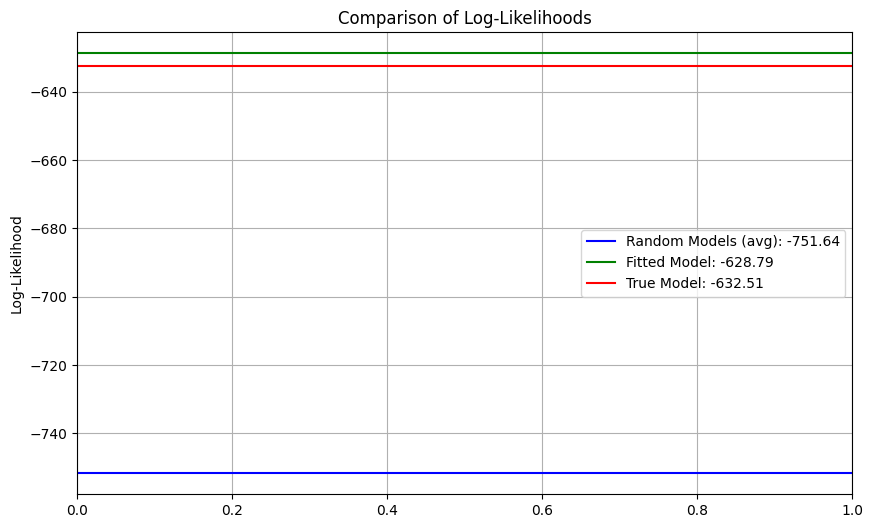

In [12]:
# 1. Log-likelihood with the fitted model
ll_fitted = fitted_model.score(X)
print(f"Log-likelihood with fitted model: {ll_fitted:.2f}")

# 2. Create a new model with the true parameters
true_model = CategoricalHMM(n_components=n_states)
true_model.startprob_ = pi
true_model.transmat_ = Q
true_model.emissionprob_ = O

# Calculate log-likelihood with true model
ll_true = true_model.score(X)
print(f"Log-likelihood with true model: {ll_true:.2f}")

# 3. Generate random models and compare
n_random_models = 20
random_lls = []

for i in range(n_random_models):
    # Generate random parameters
    random_pi = np.random.random(n_states)
    random_pi /= random_pi.sum()

    random_Q = np.random.random((n_states, n_states))
    random_Q /= random_Q.sum(axis=1, keepdims=True)

    random_O = np.random.random((n_states, n_observations))
    random_O /= random_O.sum(axis=1, keepdims=True)

    # Create and configure random model
    random_model = CategoricalHMM(n_components=n_states)
    random_model.startprob_ = random_pi
    random_model.transmat_ = random_Q
    random_model.emissionprob_ = random_O

    # Calculate log-likelihood
    ll_random = random_model.score(X)
    random_lls.append(ll_random)

# Calculate average random log-likelihood
ll_random_avg = np.mean(random_lls)

# Print results
print(f"Average log-likelihood with random models: {ll_random_avg:.2f}")

# Plot the log-likelihoods
plt.figure(figsize=(10, 6))
plt.axhline(y=ll_random_avg, color='blue', linestyle='-', label=f'Random Models (avg): {ll_random_avg:.2f}')
plt.axhline(y=ll_fitted, color='green', linestyle='-', label=f'Fitted Model: {ll_fitted:.2f}')
plt.axhline(y=ll_true, color='red', linestyle='-', label=f'True Model: {ll_true:.2f}')

plt.title('Comparison of Log-Likelihoods')
plt.ylabel('Log-Likelihood')
plt.grid(True)
plt.legend()
plt.show()

### The Label Switching Problem

One challenge when learning HMMs is the "label switching" problem. The states in our learned model might correspond to different states in the true model.

---
<font color=green>Q8:</font> <br><font color='green'>
Examine the emission matrix of the learned model. Can you determine which state in the learned model corresponds to which character (Donald, Charlie, or Neither)?
</font>  

---

In [13]:
# Let's identify the states based on their emission probabilities
# Donald: High probability (~0.9) of eating sandwich
# Charlie: Medium probability (~0.5) of eating sandwich
# Neither: Low probability (~0) of eating sandwich

# Extract probability of sandwich missing for each state
prob_sandwich_missing = learned_O[:, 1]  # Second column is sandwich missing

# Find the most likely mapping based on emission probabilities
donald_idx = np.argmax(prob_sandwich_missing)  # Highest probability of missing sandwich
neither_idx = np.argmin(prob_sandwich_missing)  # Lowest probability of missing sandwich

# Charlie is the remaining state
charlie_idx = [i for i in range(n_states) if i != donald_idx and i != neither_idx][0]

# Print the mapping
print("Mapping between learned model states and true characters:")
print(f"Learned state {donald_idx} → Donald (prob. sandwich missing: {prob_sandwich_missing[donald_idx]:.2f})")
print(f"Learned state {charlie_idx} → Charlie (prob. sandwich missing: {prob_sandwich_missing[charlie_idx]:.2f})")
print(f"Learned state {neither_idx} → Neither (prob. sandwich missing: {prob_sandwich_missing[neither_idx]:.2f})")

Mapping between learned model states and true characters:
Learned state 1 → Donald (prob. sandwich missing: 0.92)
Learned state 0 → Charlie (prob. sandwich missing: 0.88)
Learned state 2 → Neither (prob. sandwich missing: 0.21)


# Predicting the next Hidden State / Next Observation

### Predicting the Next Hidden State

Now that we have the filtered state distribution at the last time step, we can predict the distribution of the next hidden state.


---
<font color=green>Q9:</font> <br><font color='green'>
Calculate the distribution of the next hidden state: $p(H_{t+1} = h| \tilde{X}_1 = x_1, \dots, \tilde{X}_t = x_t)$ for $h \in \{0, \dots, M-1\}$ using the equation:

$p(H_{t+1} = h| \tilde{X}_1 = x_1, \dots, \tilde{X}_t = x_t) = \sum_{h'=0}^{M-1} Q_{h'h} \cdot p(H_{t} = h' | \tilde{X}_1 = x_1, \dots, \tilde{X}_t = x_t)$

Using matrix notation, if we define:
- $F = [p(H_t = h' | \tilde{X}_1 = x_1, \dots, \tilde{X}_t = x_t)]_{h' \in \{0, \dots, M-1\}} \in \mathbb{R}^{1 \times M}$
- $H = [p(H_{t+1} = h | \tilde{X}_1 = x_1, \dots, \tilde{X}_t = x_t)]_{h \in \{0, \dots, M-1\}} \in \mathbb{R}^{1 \times M}$

Then we can compute $H = F \cdot Q$
</font>  

---

<center><img width="500" src = "https://drive.google.com/uc?export=view&id=18BSCEYXHm3XKrnQ5V_L5x3NoUm_FfdPs"></center>

In [14]:
# Compute the filtered state distribution for all time steps
filtered_states = fitted_model.predict_proba(X)

# Extract the last filtering probability p(H_t = h' | X_1 = x_1, ..., X_t = x_t) for h' in {0, 1, 2}
F = filtered_states[-1]

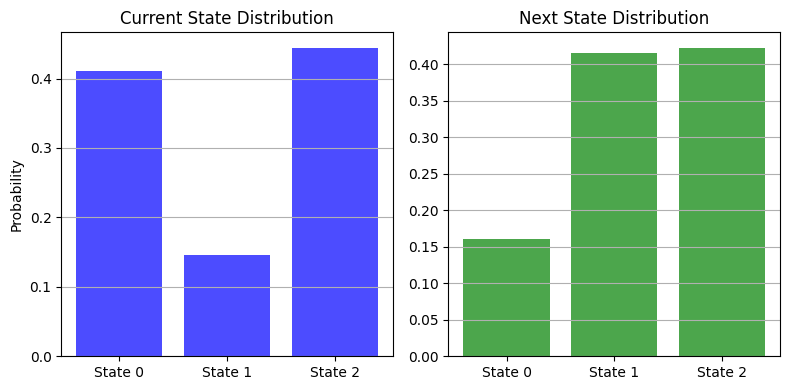

The most likely next state is State 2 with probability 0.4228


In [15]:
# Predict the next hidden state distribution using matrix multiplication
# H = F · Q
H = np.dot(F, fitted_model.transmat_)

# Visualize the current and next state distributions
states = ['State 0', 'State 1', 'State 2']
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.bar(states, F, color='blue', alpha=0.7)
plt.title('Current State Distribution')
plt.ylabel('Probability')
plt.grid(True, axis='y')

plt.subplot(1, 2, 2)
plt.bar(states, H, color='green', alpha=0.7)
plt.title('Next State Distribution')
plt.grid(True, axis='y')

plt.tight_layout()
plt.show()

# Determine the most likely next state
most_likely_next_state = np.argmax(H)
print(f"The most likely next state is State {most_likely_next_state} with probability {H[most_likely_next_state]:.4f}")

### Predicting the Next Observation

Finally, we can use the predicted next state distribution to calculate the probability distribution for the next observation.

---
<font color=green>Q10:</font> <br><font color='green'>
Calculate the distribution of the next observation: $p(\tilde{X}_{t+1} = x | \tilde{X}_1 = x_1, \dots, \tilde{X}_t = x_t)$ for $x \in \{0, 1\}$ using the equation:

$p(\tilde{X}_{t+1} = x | \tilde{X}_1 = x_1, \dots, \tilde{X}_t = x_t) = \sum_{h=0}^{M-1} O_{hx} \cdot p(H_{t+1} = h | \tilde{X}_1 = x_1, \dots, \tilde{X}_t = x_t)$

Using matrix notation, if we define:
- $P = [p(\tilde{X}_{t+1} = x | \tilde{X}_1 = x_1, \dots, \tilde{X}_t = x_t)]_{x \in \{0, 1\}} \in \mathbb{R}^{1 \times 2}$

Then we can compute $P = H \cdot O$
</font>  

---

Predicted next observation distribution:
p(X_1001 = 0 | observations) = 0.3849 (Sandwich Safe)
p(X_1001 = 1 | observations) = 0.6151 (Sandwich Missing)


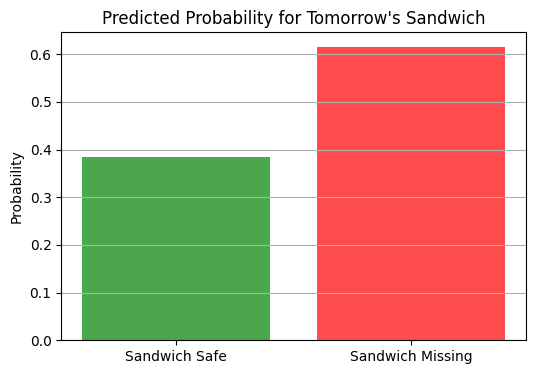

The sandwich is most likely to be missing tomorrow with probability 0.6151


In [16]:
# Calculate the next observation distribution
# P = H · O
P = np.dot(H, fitted_model.emissionprob_)

print("Predicted next observation distribution:")
print(f"p(X_{len(observations)+1} = 0 | observations) = {P[0]:.4f} (Sandwich Safe)")
print(f"p(X_{len(observations)+1} = 1 | observations) = {P[1]:.4f} (Sandwich Missing)")

# Visualize the next observation distribution
plt.figure(figsize=(6, 4))
plt.bar(['Sandwich Safe', 'Sandwich Missing'], P, color=['green', 'red'], alpha=0.7)
plt.title('Predicted Probability for Tomorrow\'s Sandwich')
plt.ylabel('Probability')
plt.grid(True, axis='y')
plt.show()

# Determine the most likely next observation
most_likely_next_obs = np.argmax(P)
obs_labels = ['safe', 'missing']
print(f"The sandwich is most likely to be {obs_labels[most_likely_next_obs]} tomorrow with probability {P[most_likely_next_obs]:.4f}")

### Conclusion



This notebook explores Hidden Markov Models through a practical example of Dr. Ross Geller's missing sandwich problem. The content is structured in three main sections:

#### 1. Introducing the Problem and Generating the Data
- **Introducing the Hidden States**: Sets up a scenario where Dr. Geller's sandwiches go missing, with three possible hidden states (Donald present, Charlie present, or neither present)
- **Introducing the Parameters of the Hidden Markov Model**: Defines the model parameters - initial state distribution (π), transition matrix (Q), and emission matrix (O)
- **Generating the Synthetic Data**: Creates simulated data using the HMM parameters to represent 1000 days of sandwich observations

#### 2. The Learning Problem: EM Algorithm
- **Fitting the Model Using hmmlearn**: Implements the Expectation-Maximization algorithm to learn the model parameters from observations only
- **Comparing Log Likelihoods**: Evaluates model quality by comparing log-likelihoods of fitted, true, and random models
- **The Label Switching Problem**: Addresses the issue of state identifiability in learned HMMs and reorders states to match original interpretations

#### 3. Predicting the Next Hidden State / Next Observation
- **Predicting the Next Hidden State**: Uses filtering probabilities to predict the next hidden state
- **Predicting the Next Observation**: Calculates the probability of Dr. Geller's sandwich going missing, enabling him to make informed decisions about his sandwich security based on data-driven predictions


These techniques have broad applications including:
- Speech recognition
- Natural language processing
- Biological sequence analysis
- Financial market regime modeling


### Contact

If you have any question regarding this notebook, do not hesitate to contact: h.madmoun@imperial.ac.uk